In [2]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import json
from scipy.signal import savgol_filter

In [17]:
with open('input.yml') as file:
            settings = yaml.load(file, Loader=yaml.FullLoader)

In [18]:
settings

{'paths': {'data': {'external': 'X:/user/dekkerm/Data/',
   'baseline': 'X:/user/heerdenvr/Downscaling/Mark/14_09_2023/',
   'internal': 'Data/',
   'datadrive': 'K:/ECEMF/T5.2/'},
  'task': 'X:/user/dekkerm/Projects/ECEMF_T5.2/'},
 'params': {'pcc_conv_start': 2040,
  'pcc_conv_end': 2150,
  'convergence_year_gdr': 2150,
  'convergence_year_base': 2150,
  'historical_emissions_startyear': 1950,
  'discount_factor': 0.015,
  'version_ndcs': '13Mar2023a',
  'gwp_ch4': 27.2,
  'gwp_n2o': 273,
  'gwp_ch4_ar4': 25,
  'gwp_n2o_ar4': 298,
  'start_year_analysis': 2021,
  'polynomial_fit_2030relation': None},
 'standard_settings': {'Risk_of_exceedance': 0.4,
  'Negative_emissions': 0.2,
  'Non_CO2_mitigation_potential': 0.4}}

In [5]:
settings['paths']['data']['datadrive']

'K:/ECEMF/T5.2/'

In [6]:
countries_iso = np.load(settings['paths']['data']['datadrive']+ 'all_countries.npy', allow_pickle=True)

In [7]:
countries_iso

array(['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG', 'ARM', 'AUS',
       'AUT', 'AZE', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN',
       'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'BRN', 'BGR', 'BFA', 'BDI',
       'KHM', 'CMR', 'CAN', 'CPV', 'CAF', 'TCD', 'CHL', 'CHN', 'COL',
       'COM', 'COG', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CYP', 'CZE',
       'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ',
       'ERI', 'EST', 'SWZ', 'ETH', 'FJI', 'FIN', 'FRA', 'GAB', 'GEO',
       'DEU', 'GHA', 'GRC', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY', 'HTI',
       'VAT', 'HND', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL',
       'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KIR', 'KWT',
       'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU',
       'LUX', 'MKD', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL',
       'MRT', 'MUS', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MAR',
       'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NZL', 'NIC', 'NER',
       'NGA', 'NIU',

In [8]:
xr_total = xr.open_dataset(settings['paths']['data']['datadrive'] + "xr_dataread.nc").sel()

In [9]:
xr_total

<xarray.Dataset>
Dimensions:            (Scenario: 5, Region: 207, Time: 251, Conditionality: 3,
                        Hot_air: 2, Ambition: 2, Temperature: 11, Risk: 5,
                        NegEmis: 7, TrajUnc: 5)
Coordinates:
  * Scenario           (Scenario) object 'SSP1' 'SSP2' 'SSP3' 'SSP4' 'SSP5'
  * Region             (Region) object 'AFG' 'ALB' ... 'Umbrella'
  * Time               (Time) int32 1850 1851 1852 1853 ... 2097 2098 2099 2100
  * Conditionality     (Conditionality) object 'conditional' ... 'unconditional'
  * Hot_air            (Hot_air) object 'include' 'exclude'
  * Ambition           (Ambition) object 'low' 'high'
  * Temperature        (Temperature) float64 1.4 1.5 1.6 1.7 ... 2.1 2.2 2.3 2.4
  * Risk               (Risk) float64 0.17 0.33 0.5 0.67 0.83
  * NegEmis            (NegEmis) float64 0.2 0.3 0.4 0.5 0.6 0.7 0.8
  * TrajUnc            (TrajUnc) object 'Earliest' 'Early' ... 'Late' 'Latest'
    source             object ...
    Version            object ...
Data variables: (12/16)
    GDP                (Scenario, Region, Time) float64 ...
    Population         (Scenario, Region, Time) float64 ...
    GHG_hist           (Time, Region) float64 ...
    CO2_hist           (Time, Region) float64 ...
    N2O_hist           (Time, Region) float64 ...
    CH4_hist           (Time, Region) float64 ...
    ...                 ...
    GHG_globe          (NegEmis, TrajUnc, Temperature, Risk, Time) float64 ...
    CO2_globe          (NegEmis, TrajUnc, Temperature, Risk, Time) float64 ...
    CH4_globe          (Temperature, Risk, Time) float64 ...
    N2O_globe          (Temperature, Risk, Time) float64 ...
    GHG_base           (Region, Scenario, Time) float64 ...
    GHG_ndc            (Region, Conditionality, Hot_air, Ambition, Time) float64 ...

### Try out converting for loop to pandas

In [48]:
time = np.arange(1850, 2100)
convyear = 2040
start_year_analysis = 2021
xr_total = xr.open_dataset(settings['paths']['data']['datadrive'] + "xr_dataread.nc").sel()
FocusRegion = 'EU'
countries_iso = np.load(settings['paths']['data']['datadrive'] + "all_countries.npy", allow_pickle=True)

def transform_time(time, convyear):
    fractions = pd.Series(index=time, dtype=float)

    fractions[time < start_year_analysis + 1] = 1
    fractions[(time >= start_year_analysis + 1) & (time < convyear)] = 1 - (time - start_year_analysis) / (convyear - start_year_analysis)
    fractions[time >= convyear] = 0

    return fractions.tolist()

In [49]:
# Defining the timeframes for historical and future emissions
hist_emissions_startyear = settings['params']['historical_emissions_startyear']
hist_emissions_timeframe = np.arange(hist_emissions_startyear, 1 + start_year_analysis)
future_emissions_timeframe = np.arange(start_year_analysis+1, 2101)

# Summing all historical emissions over the hist_emissions_timeframe
hist_emissions = xr_total.GHG_hist.sel(Time = hist_emissions_timeframe).sum(dim='Time')
hist_emissions_w = float(hist_emissions.sel(Region='EARTH'))
hist_emissions_r = float(hist_emissions.sel(Region = FocusRegion))

# Summing all future emissions over the future_emissions_timeframe
future_emissions_w = xr_total.GHG_globe.sel(Time = future_emissions_timeframe).sum(dim='Time')

total_emissions_w = hist_emissions_w + future_emissions_w

# Calculating the cumulative population shares for region and world
cum_pop = xr_total.Population.sel(Time = np.arange(hist_emissions_startyear, 2101)).sum(dim='Time')
cum_pop_r = cum_pop.sel(Region=FocusRegion)
cum_pop_w = cum_pop.sel(Region=countries_iso).sum(dim='Region')
share_cum_pop = cum_pop_r / cum_pop_w
budget_rightful = total_emissions_w * share_cum_pop
budget_left = budget_rightful - hist_emissions_r

In [54]:
budget_left

<xarray.DataArray (NegEmis: 7, TrajUnc: 5, Temperature: 11, Risk: 5, Scenario: 5)>
array([[[[[ -95943.20623068, -113396.99967184, -148266.00948154,
           -123228.37416579,  -78149.13425163],
          [ -90770.13533063, -108681.463593  , -144464.53178332,
           -118770.55834623,  -72509.60844773],
          [ -84234.48473529, -102723.86185574, -139661.75013551,
           -113138.56002686,  -65384.63937427],
          [ -78215.40106343,  -97237.13902423, -135238.5723395 ,
           -107951.70546211,  -58822.81597399],
          [ -69582.57128093,  -89367.84415307, -128894.65969559,
           -100512.49461124,  -49411.56543061]],

         [[ -86691.17981422, -104963.27332009, -141467.07461963,
           -115255.57995532,  -68062.85422144],
          [ -79168.85102534,  -98106.26063143, -135939.22362316,
           -108773.32658533,  -59862.23835323],
          [ -70813.1925101 ,  -90489.62247734, -129798.99277898,
           -101572.96389328,  -50753.1515621 ],
          [ -62527.2748383 ,  -82936.55690319, -123710.01162113,
            -94432.69932111,  -41720.09413414],
          [ -48727.38232656,  -70357.20272834, -113569.03643737,
...
            -44766.48398621,   21111.99994519],
          [  18017.97142848,   -9515.17488671,  -64520.61265544,
            -25024.04826336,   46087.90298771],
          [  42502.5606904 ,   12803.86273547,  -46527.89192386,
             -3924.82278277,   72780.26340732],
          [  74432.97430179,   41910.17507997,  -23063.5401715 ,
             23590.72952111,  107589.83686373],
          [ 129433.70114819,   92046.33536432,   17354.23884841,
             70986.77627177,  167549.96968935]],

         [[   5401.52145584,  -21015.75668473,  -73791.92444072,
            -35896.08372574,   32333.82991409],
          [  30621.36346412,    1973.50389002,  -55258.89661266,
            -14163.26528123,   59827.74069241],
          [  57172.06718981,   26175.91745759,  -35747.87307647,
              8716.40317406,   88772.51675785],
          [  91722.72069268,   57670.72127693,  -10358.01446293,
             38489.90768175,  126438.59668129],
          [ 152007.81862408,  112623.87382503,   33943.03219759,
             90439.68150756,  192159.59141408]]]]])
Coordinates:
  * Temperature  (Temperature) float64 1.4 1.5 1.6 1.7 1.8 ... 2.1 2.2 2.3 2.4
  * Risk         (Risk) float64 0.17 0.33 0.5 0.67 0.83
  * NegEmis      (NegEmis) float64 0.2 0.3 0.4 0.5 0.6 0.7 0.8
  * TrajUnc      (TrajUnc) object 'Earliest' 'Early' 'Medium' 'Late' 'Latest'
    source       <U25 'PRIMAP-hist_v2.5_final_nr'
    Version      <U6 'HISTTP'
  * Scenario     (Scenario) object 'SSP1' 'SSP2' 'SSP3' 'SSP4' 'SSP5'
    Region       <U2 'EU'

(array([35.,  0.,  0., 35., 35.,  0.,  0., 35.,  0., 35.]),
 array([-129798.99277898, -121894.40865729, -113989.82453561,
        -106085.24041392,  -98180.65629223,  -90276.07217054,
         -82371.48804886,  -74466.90392717,  -66562.31980548,
         -58657.73568379,  -50753.1515621 ]),
 <BarContainer object of 10 artists>)

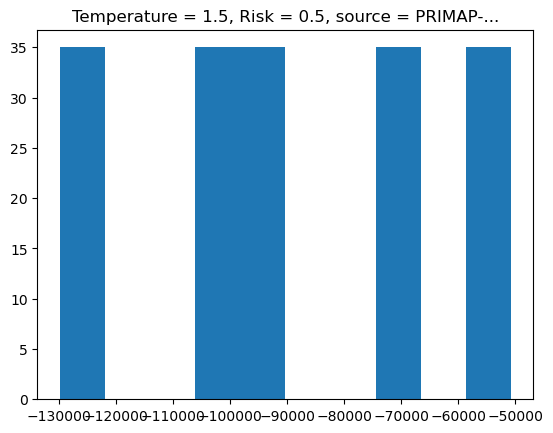

In [60]:
budget_left.sel(Temperature=1.5, Risk=0.5).plot()